In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)

In [9]:
# To see columns in Measurement table with data types
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [10]:
# To see columns in Station table with data types
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [11]:
# Get last data point year, month and day to calculate 1 year ago from last data point

last_date=session.query(Measurement.date).\
order_by(Measurement.date.desc()).first()

for each in last_date:
    split_last_date=each.split('-')
    
print(split_last_date)
last_year=int(split_last_date[0]); last_month=int(split_last_date[1]); last_day=int(split_last_date[2])
print(last_year)
print(last_month)
print(last_day)

['2017', '08', '23']
2017
8
23


In [12]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(last_year, last_month, last_day) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_12months_prcp=session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date>=query_date).\
order_by(Measurement.date).all()
#last_12months_prcp

In [14]:

# Save the query results as a Pandas DataFrame and set the index to the date column

df_last_12months_prcp=pd.DataFrame(last_12months_prcp,columns=['date', 'prcp'])
df_last_12months_prcp.set_index('date', inplace=True)

In [15]:
# Drop Nans

df_last_12months_prcp=df_last_12months_prcp.dropna()

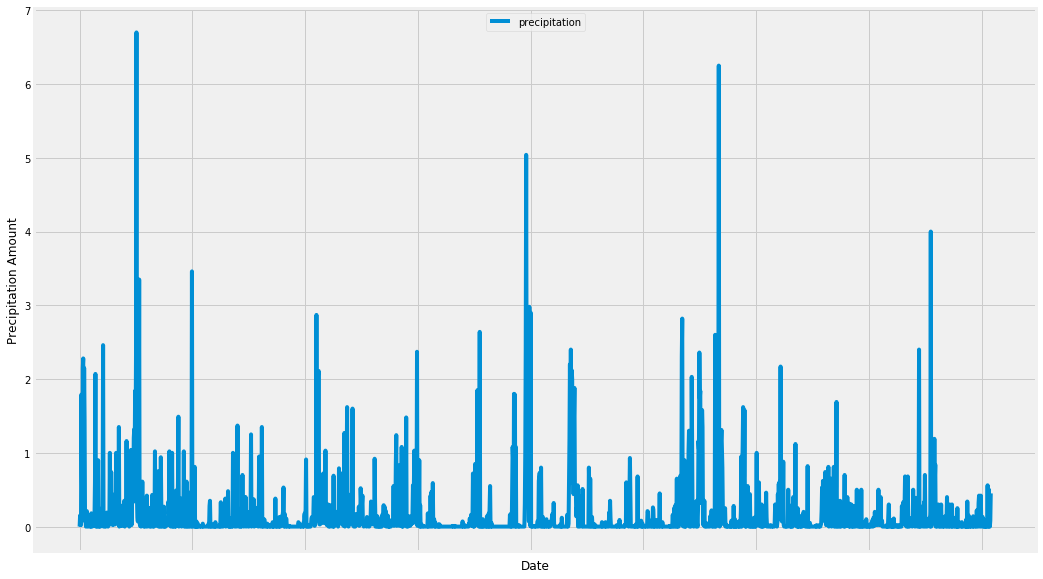

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

df_last_12months_prcp.plot(figsize=(16,10))
plt.ylabel('Precipitation Amount')
plt.xlabel('Date')
plt.legend(["precipitation"],loc="upper center")
#plt.title('Precipitation')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_last_12months_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:

# Design a query to show how many stations are available in this dataset?
total_stations=session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

min_max_avg_tmp=session.query(*sel).group_by(Measurement.station). \
order_by(func.count(Measurement.station).desc()).first()
min_max_avg_tmp

('USC00519281', 54.0, 85.0, 71.66378066378067)

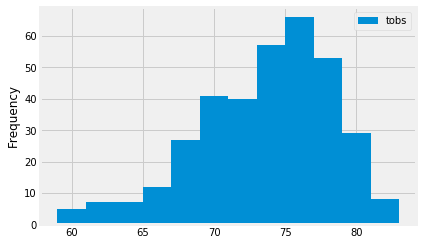

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station=min_max_avg_tmp[0]

last_12months_tobs_top_station=session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station==top_station).\
filter(Measurement.date>=query_date).\
order_by(Measurement.date).all()
df_top_station_tobs_last_12months=pd.DataFrame(last_12months_tobs_top_station,columns=['date','tobs'])
df_top_station_tobs_last_12months.plot.hist(bins=12)
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_bar = calc_temps('2017-07-01','2017-07-14')
print(temp_bar)

[(69.0, 78.11627906976744, 87.0)]


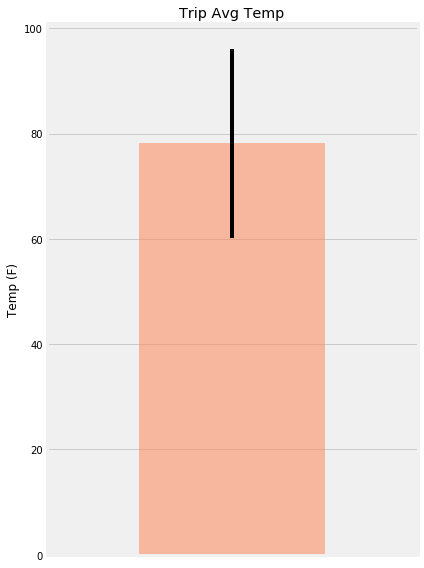

In [25]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(temp_bar, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(6,8))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()